In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [2]:
def zone_sampling(zones,m):#input=zones as a list of tuples [(l1,u1),(l2,u2),..,]
    samples=[np.linspace(i[0], i[1], math.ceil((i[1]-i[0])*m/np.pi)) for i in zones]#calculate how many samples out of m correspond to each zone
    return samples

def weight(x,zones,gains):
    for ind, zone in enumerate(zones):
        if x>=zone[0] and x<=zone[1]:
            return gains[ind]
        
def filter(x,zones,start):#start boolean denoting if the first zone is pass or stop
    for i in zones:
        if x>=i[0] and x<=i[1]:
            return start
        start^=1 #invert start
        
def initializeMatrices(zones,gains,start,L):#L length of filter
    K=L//2 + 1
    freqs = np.concatenate(zone_sampling(zones,10*L))#contains alla frequencies samples
    
    return np.transpose([np.cos(n*freqs) for n in range(K)]), np.array([weight(x,zones,gains) for x in freqs]),np.array([filter(x,zones,start) for x in freqs])

In [3]:
def filter_approximation(baseMatrix,coefficients):
    return np.array([np.inner(coefficients,x) for x in baseMatrix])

In [4]:
def Remez(baseMatrix,weight_vector,ideal, epsilon=1e-8):
    N=len(baseMatrix[0])-1
    
    '''step 1,2'''
    start_time = time.time()
    loop=1 #used to track progress
    
    A = np.array([[sum(baseMatrix[:,i]*baseMatrix[:,j]*weight_vector**2) for i in range(N+1)] for j in range(N+1)])
    b = np.array([sum(baseMatrix[:,i]*ideal*weight_vector**2) for i in range(N+1)])

    c_n = np.linalg.solve(A, b) #coefficients initialization
    
    init_time=time.time()
    print('Τime for initialization:',init_time - start_time)
    
    
    '''step 3'''
    while True:
        approximation = filter_approximation(baseMatrix,c_n) #c_0 + 2c_1cosw ....
        error = (approximation - ideal)*weight_vector #error vector used to split frequencies into zones
        sign_zone=[error[0]] #vector used to store errors for each frequency zone
        reduced_freqs=[] #vector used to store frequencies that satisfy the alternation theorem
        
        for ind,e in enumerate(error[1:]): #iterate over the error vector

            if np.sign(sign_zone[-1])==np.sign(e): #if the sign of current element is the same as the last element of the
                sign_zone.append(e)                #zone vector, therefore both elements occupy the same zone

            else:#else the zone stops and we have to create a new one
                max_index=1+ind-len(sign_zone)+np.argmax(np.abs(sign_zone)) #find argmax of absolute of current zone
                reduced_freqs.append(max_index) #store it in alternation freqs vector
                sign_zone=[e] #re-initialize zone vector

        reduced_freqs.append(2+ind-len(sign_zone)+np.argmax(np.abs(sign_zone))) #argmax of the last zone
        error_per_freq = [np.abs(error[i]) for i in reduced_freqs] #error vector for each frequency in alternation freqs vector

        '''step 4'''
        
        while True:
            M = len(reduced_freqs) #frequencies remaining in alternation freqs vector
            K = N + 1


            if M==K + 1: #exactly K+1 freqs are required
                break

            elif M==K + 2 or (M-K)%2==0: #case 2 and 4b of remez step 4
                if error_per_freq[0] > error_per_freq[-1]: #compare first and last element and remove
                    reduced_freqs=reduced_freqs[0:M-1]     #the one with lowest error from both alternation
                    error_per_freq=error_per_freq[0:M-1]   #freqs vector and error vector
                else:
                    reduced_freqs=reduced_freqs[1:]
                    error_per_freq=error_per_freq[1:]

            elif M==K + 3 or (M-K)%2==1: #case 3 and 4a of remez step 4
                freq_to_remove = np.argmin(error_per_freq) #find lowest error frequency
                                                           #and remove both this and its adjacent with the lowest error
                if error_per_freq[freq_to_remove-1] > error_per_freq[(freq_to_remove+1)%M]:
                    del reduced_freqs[freq_to_remove], reduced_freqs[freq_to_remove%len(reduced_freqs)]
                    del error_per_freq[freq_to_remove], error_per_freq[freq_to_remove%len(error_per_freq)]

                else:
                    del reduced_freqs[freq_to_remove], reduced_freqs[freq_to_remove-1]
                    del error_per_freq[freq_to_remove], error_per_freq[freq_to_remove-1]
        
        '''step 5'''
        remA=np.array([list(baseMatrix[i])+[((-1)**ind)/weight_vector[i]] for ind, i in enumerate(reduced_freqs)]) #matrix A
        remb = np.array([ideal[i] for i in reduced_freqs]) #target matrix b containing the ideal filter response
        remx=np.linalg.solve(remA, remb) #filter coefficients acquired after solving the minmax problem
        
        print('iteration:',loop,'error',np.abs(max(error_per_freq) - min(error_per_freq)))
        
        if np.abs(max(error_per_freq) - min(error_per_freq)) < epsilon:   #chech if requirements are satisfied
            print('time elapsed',time.time() - start_time,'\nδ=',remx[-1])#by getting the max and min error for
                                                                          #the frequencies used in the minmax
 
            
            return c_n                                                  
        else:
            loop+=1
            c_n = np.copy(remx[:-1]) #if requirements are not satisfied, repeat from step 3 using minmax coefficients


Τime for initialization: 0.14999008178710938
iteration: 1 error 0.015770565533358427
iteration: 2 error 0.002241373158882398
iteration: 3 error 0.00014051731750874819
iteration: 4 error 3.552713678800501e-15
time elapsed 0.17699027061462402 
δ= -0.0059882606759238365


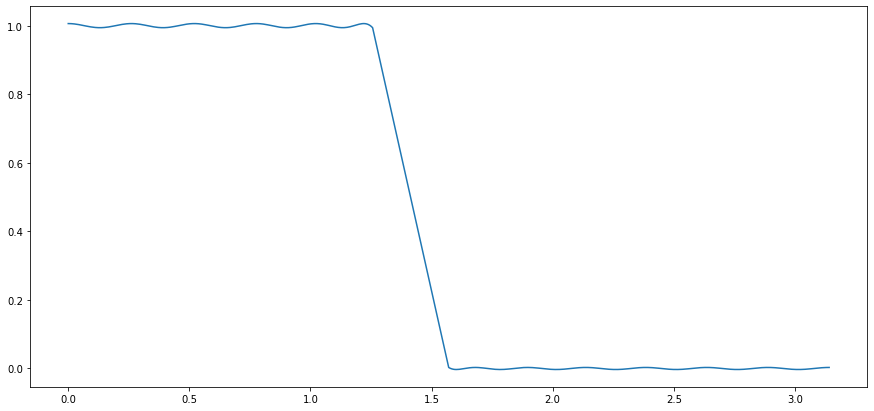

In [5]:
L=51
zones=[(0,0.4*np.pi), (0.5*np.pi,np.pi)]
freqs = np.concatenate(zone_sampling(zones,10*L))
gains=[1,2]
start=1


baseMatrix, weight_vector, ideal = initializeMatrices(zones,gains,start,L)
coefficients = Remez(baseMatrix,weight_vector,ideal)

fig= plt.figure(figsize=(15,7))
plt.plot(freqs,filter_approximation(baseMatrix,coefficients))

ΑΣΚΗΣΗ 2

In [6]:
def linprog_filter(baseMatrix, weight_vector, ideal):
    start=time.time()
    K=len(baseMatrix[0])
    lpA=[]
    lpb=[]
    lpF=[0]*K + [1]
    
    for ind,i in enumerate(baseMatrix): #iterrate over baseMatrix rows to construct A and b for linprog
        lpA.append(list(i)+[-1/weight_vector[ind]])
        lpA.append(list(-i)+[-1/weight_vector[ind]])
        
        lpb.append(ideal[ind])
        lpb.append(-ideal[ind])
    
    res = linprog(lpF, A_ub=lpA, b_ub=lpb, bounds = (None, None),options={'tol':1e-7})#keep low tolerance to avoid warnings
    print('time elapsed:',time.time()-start)
    print('δ=',res.x[-1])
    return res.x[:-1] #return coefficients

time elapsed: 0.8676085472106934
δ= 0.0059882597757717395


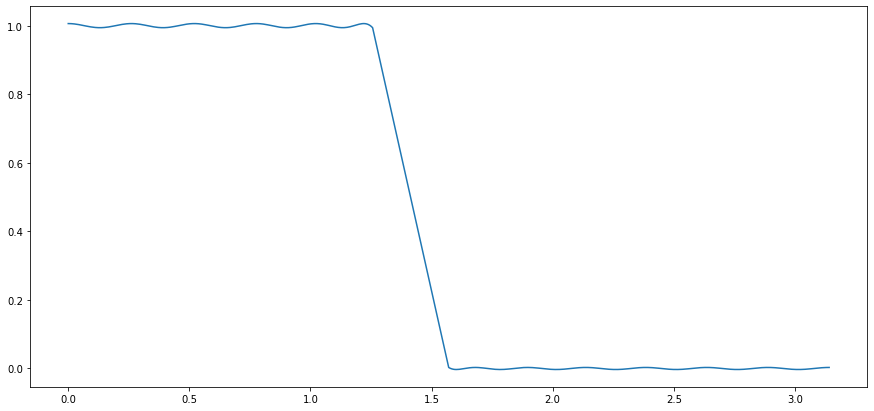

In [7]:
from scipy.optimize import linprog

L=51
zones=[(0,0.4*np.pi), (0.5*np.pi,np.pi)]
freqs = np.concatenate(zone_sampling(zones,10*L))
gains=[1,2]
start=1


baseMatrix, weight_vector, ideal = initializeMatrices(zones,gains,start,L)
lp_coefficients = linprog_filter(baseMatrix,weight_vector,ideal)

fig= plt.figure(figsize=(15,7))
plt.plot(freqs,filter_approximation(baseMatrix,lp_coefficients))

ΑΣΚΗΣΗ 3

In [10]:
def Remez_Eq(baseMatrix,weight_vector,ideal,eq_freqs,D,epsilon=1e-8):
    N=len(baseMatrix[0])-1
    l=len(eq_freqs)
    
    '''step 1,2'''
    start_time = time.time()
    loop=1
    
    Q = np.array([[sum(baseMatrix[:,i]*baseMatrix[:,j]*weight_vector**2) for i in range(N+1)] for j in range(N+1)])
    A = np.transpose([np.cos(n*eq_freqs) for n in range(N+1)])

    Eq_A = np.concatenate((np.append(Q, np.transpose(A), axis=1),np.append(A, np.zeros((l,l)), axis=1)),axis=0)
    Eq_b = np.concatenate((np.array([sum(baseMatrix[:,i]*ideal*weight_vector**2) for i in range(N+1)]),D),axis=0)
    Eq_x = np.linalg.solve(Eq_A, Eq_b)

    a_n = Eq_x[:N+1]
    
    init_time=time.time()
    print('Τime for initialization:',init_time - start_time)
    
    
    '''step 3'''
    while True:
        approximation = filter_approximation(baseMatrix,a_n) #a_0 + 2a_1cosw ....
        error = (approximation - ideal)*weight_vector #error vector used to split frequencies into zones
        sign_zone=[error[0]] #vector used to store errors for each frequency zone
        reduced_freqs=[] #vector used to store frequencies that satisfy the alternation theorem
        
        for ind,e in enumerate(error[1:]): #iterate over the error vector

            if np.sign(sign_zone[-1])==np.sign(e): #if the sign of current element is the same as the last element of the
                sign_zone.append(e)                #zone vector, therefore both elements occupy the same zone

            else:#else the zone stops and we have to create a new one
                max_index=1+ind-len(sign_zone)+np.argmax(np.abs(sign_zone)) #find argmax of absolute of current zone
                reduced_freqs.append(max_index) #store it in alternation freqs vector
                sign_zone=[e] #re-initialize zone vector

        reduced_freqs.append(2+ind-len(sign_zone)+np.argmax(np.abs(sign_zone))) #argmax of the last zone

        error_per_freq = [np.abs(error[i]) for i in reduced_freqs] #error vector for each frequency in alternation freqs vector

        '''step 4'''
        
        while True:
            M = len(reduced_freqs) #frequencies remaining in alternation freqs vector
            K = N + 1 - l

            if M==K + 1: #exactly N+1 freqs are required
                break

            elif M==K + 2 or (M-K)%2==0:
                if error_per_freq[0] > error_per_freq[-1]:
                    reduced_freqs=reduced_freqs[0:M-1]
                    error_per_freq=error_per_freq[0:M-1]
                else:
                    reduced_freqs=reduced_freqs[1:]
                    error_per_freq=error_per_freq[1:]

            elif M==K + 3 or (M-K)%2==1:
                freq_to_remove = np.argmin(error_per_freq)

                if error_per_freq[freq_to_remove-1] > error_per_freq[(freq_to_remove+1)%M]:
                    del reduced_freqs[freq_to_remove], reduced_freqs[freq_to_remove%len(reduced_freqs)]
                    del error_per_freq[freq_to_remove], error_per_freq[freq_to_remove%len(error_per_freq)]

                else:
                    del reduced_freqs[freq_to_remove], reduced_freqs[freq_to_remove-1]
                    del error_per_freq[freq_to_remove], error_per_freq[freq_to_remove-1]
        
        '''step 5'''
        remA = np.concatenate((np.array([list(baseMatrix[i])+[((-1)**ind)/weight_vector[i]] for ind, i in enumerate(reduced_freqs)]),np.append(A, np.zeros((l,1)),axis=1)), axis=0) #matrix A
        remb = np.concatenate((np.array([ideal[i] for i in reduced_freqs]),D), axis=0) #target matrix b containing the ideal filter response
        remx = np.linalg.solve(remA, remb) #filter coefficients acquired after solving the minmax problem
        print('iteration:',loop,'error',np.abs(max(error_per_freq) - min(error_per_freq)))
        if np.abs(max(error_per_freq) - min(error_per_freq)) < epsilon: #chech if requirements are satisfied
            print('time elapsed',time.time() - start_time,'\nδ=',remx[-1]) #by getting the max and min error for
                                                                        #the frequencies used in the minmax
 
            
            return a_n                                                  
        else:
            loop+=1
            a_n = np.copy(remx[:-1]) #if requirements are not satisfied, repeat from step 3 using minmax coefficients


Τime for initialization: 0.11099696159362793
iteration: 1 error 0.021982461747654947
iteration: 2 error 0.6850896508171213
iteration: 3 error 0.021936763644921052
iteration: 4 error 0.0018959772581588208
iteration: 5 error 5.4862864501570296e-05
iteration: 6 error 2.8449465006019636e-15
time elapsed 0.13700461387634277 
δ= 0.00978862513415656


<module 'matplotlib.pyplot' from 'C:\\Users\\krist\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

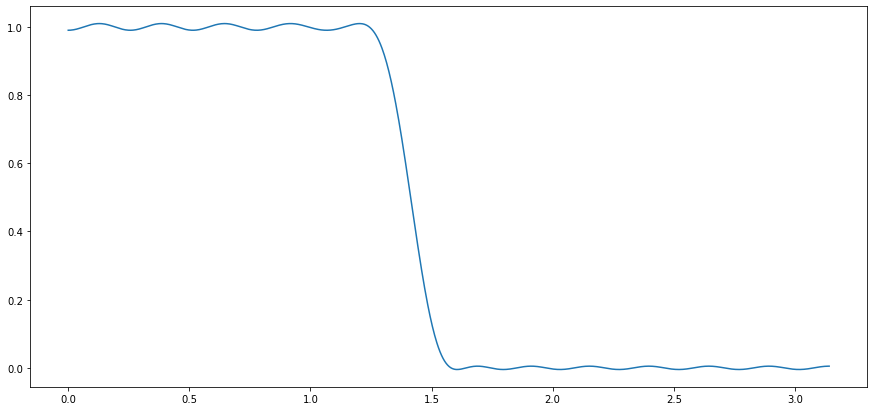

In [11]:
eq_freqs = np.array([0.45*np.pi])
D = np.array([0.5])

L=51
zones=[(0,0.4*np.pi), (0.5*np.pi,np.pi)]
freqs = np.concatenate(zone_sampling(zones,10*L))
gains=[1,2]
start=1


baseMatrix, weight_vector, ideal = initializeMatrices(zones,gains,start,L)
coefficients = Remez_Eq(baseMatrix,weight_vector,ideal,eq_freqs,D)

fig= plt.figure(figsize=(15,7))
x=np.linspace(0,np.pi,1000)
y=np.array([np.inner(coefficients,x) for x in np.transpose([np.cos(n*x) for n in range(L//2+1)])])
plt.plot(x,y)
plt

In [13]:
def Eq_linprog_filter(baseMatrix, weight_vector, ideal, eq_freqs, D):
    K=len(baseMatrix[0])
    lpA=[]
    lpb=[]
    lpF=[0]*K + [1]
    
    for ind,i in enumerate(baseMatrix):
        lpA.append(list(i)+[-1/weight_vector[ind]])
        lpA.append(list(-i)+[-1/weight_vector[ind]])
        
        lpb.append(ideal[ind])
        lpb.append(-ideal[ind])
    

    eq_A = [[np.cos(n*i) for n in range(K)]+[0] for i in eq_freqs] 
    eq_b = D

    
    res = linprog(lpF, A_ub=lpA, b_ub=lpb, A_eq=eq_A, b_eq=eq_b, bounds = (None, None),options={'tol':1e-6})
    print('error',res.x[-1])
    return res.x[:-1]

error 0.007332709667555932


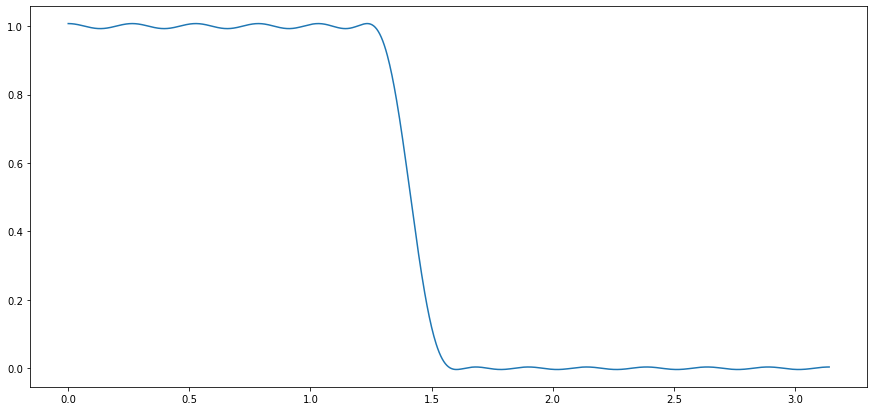

In [14]:
from scipy.optimize import linprog

eq_freqs = np.array([0.45*np.pi])
D = np.array([0.5])
L=51
zones=[(0,0.4*np.pi), (0.5*np.pi,np.pi)]
freqs = np.concatenate(zone_sampling(zones,10*L))
gains=[1,2]
start=1


baseMatrix, weight_vector, ideal = initializeMatrices(zones,gains,start,L)
lp_coefficients = Eq_linprog_filter(baseMatrix,weight_vector,ideal,eq_freqs,D)

fig= plt.figure(figsize=(15,7))
x=np.linspace(0,np.pi,1000)
y=np.array([np.inner(lp_coefficients,x) for x in np.transpose([np.cos(n*x) for n in range(L//2+1)])])
plt.plot(x,y)